# Simple Geometry dataset

In [1]:
import os
import sys
sys.path.append('/usr/lib/python3/dist-packages')
print(sys.path)
import numpy as np
import torch
import matplotlib.pyplot as plt
from scipy.spatial import distance
import scipy.interpolate
%matplotlib inline
from pix_transform.pix_transform import PixTransform
from baselines.baselines import bicubic
from utils.utils import downsample,align_images
from prox_tv import tvgen
from utils.plots import plot_result
import imageio

['/home/beast2020/Desktop/mingchi/PixTransform-save_params', '/home/beast2020/anaconda3/lib/python38.zip', '/home/beast2020/anaconda3/lib/python3.8', '/home/beast2020/anaconda3/lib/python3.8/lib-dynload', '', '/home/beast2020/.local/lib/python3.8/site-packages', '/home/beast2020/anaconda3/lib/python3.8/site-packages', '/home/beast2020/.local/lib/python3.8/site-packages/IPython/extensions', '/home/beast2020/.ipython', '/usr/lib/python3/dist-packages']


In [15]:
# maybe need to delete

pose_dir = '/home/beast2020/Desktop/mingchi/Dataset_with_simple_geometry/mydataset_7_poses.npy'
init_dir1 = '/home/beast2020/Desktop/mingchi/Dataset_with_simple_geometry/mydataset_7_00002_pc.npy'
init_dir2 = '/home/beast2020/Desktop/mingchi/Dataset_with_simple_geometry/mydataset_7_00005_pc.npy'

rgb_dir1 = '/home/beast2020/Desktop/mingchi/Dataset_with_simple_geometry/mydataset_7_00002_img.png'
rgb_dir2 = '/home/beast2020/Desktop/mingchi/Dataset_with_simple_geometry/mydataset_7_00005_img.png'

dist_dir = '/home/beast2020/Desktop/mingchi/Dataset_with_simple_geometry/'
save_dir = '/home/beast2020/Desktop/mingchi/Dataset_with_simple_geometry/plots'



### Calculate distance

In [3]:
pose = np.load(pose_dir)
pose1 = pose[2,0:3]
pose2 = pose[5,0:3]

init1 = np.load(init_dir1)
init2 = np.load(init_dir2)

dist1 = np.zeros((init1.shape[0], init1.shape[1]))
dist2 = np.zeros((init2.shape[0], init2.shape[1]))

for row in range(init1.shape[0]):
    for col in range(init1.shape[1]):
        dist1[row,col] = distance.euclidean(init1[row,col,:], pose1)
        
for row in range(init2.shape[0]):
    for col in range(init2.shape[1]):
        dist2[row,col] = distance.euclidean(init2[row,col,:], pose2)
        
dist1 = torch.from_numpy(dist1)
dist2 = torch.from_numpy(dist2)
torch.save(dist1, dist_dir+'/dist2.dat')
torch.save(dist2, dist_dir+'/dist5.dat')

In [4]:
dist1.shape

torch.Size([480, 720])

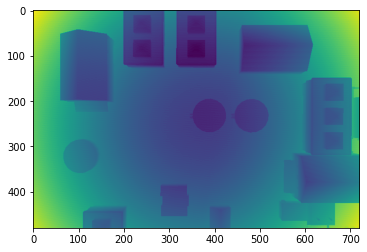

In [5]:
plt.imshow(dist1)

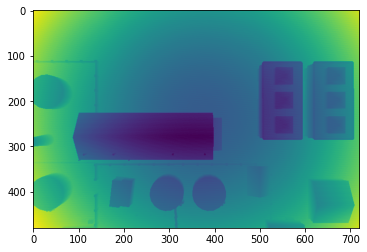

In [6]:
plt.imshow(dist2)

In [7]:
_rgb_files = '/home/beast2020/Desktop/mingchi/Dataset_with_simple_geometry/mydataset_7_00002_img.png'
_dist_files = '/home/beast2020/Desktop/mingchi/Dataset_with_simple_geometry/dist2.dat'

# _rgb_files = '/home/beast2020/Desktop/mingchi/Dataset_with_simple_geometry/mydataset_7_00005_img.png'
# _dist_files = '/home/beast2020/Desktop/mingchi/Dataset_with_simple_geometry/dist5.dat'

## Test hyperparameter x8

In [8]:
rgb_img = imageio.imread(_rgb_files)
guide_imgs = rgb_img[:,:,0:3]
dist_img = torch.load(_dist_files)
dist_img = dist_img.detach().cpu().numpy()
target_imgs = dist_img
        
guide_imgs = np.asarray(guide_imgs)  
guide_imgs = np.einsum('ijk->kij', guide_imgs)   
target_imgs = np.asarray(target_imgs)

print(guide_imgs.shape)
print('max value in the image is: ' + str(guide_imgs.max()))
print('min value in the image is: ' + str(guide_imgs.min()))

print(target_imgs.shape)
print('max value in the image is: ' + str(target_imgs.max()))
print('min value in the image is: ' + str(target_imgs.min()))

(3, 480, 720)
max value in the image is: 226
min value in the image is: 10
(480, 720)
max value in the image is: 96.41430554631606
min value in the image is: 63.67227026643547


In [9]:
####  define parameters  ########################################################
params = {'img_idxs' : [], # idx images to process, if empty then all of them
            
          'scaling': 8,
          'greyscale': False, # Turn image into grey-scale
          'channels': -1,
          
          'spatial_features_input': True,
          'weights_regularizer': [0.0001, 0.001, 0.0001], # spatial color head
          'loss': 'l1',
 
          'optim': 'adam',
          'lr': 0.001,
                  
          'batch_size': 32,
          'iteration': 1024*60*90//32, # could //4 or //16 for debugging, so to save time
                  
          'logstep': 16,
          
          'final_TGV' : False, # Total Generalized Variation in post-processing
          'align': False, # Move image around for evaluation in case guide image and target image are not perfectly aligned
          'delta_PBP': 1, # Delta for percentage of bad pixels 
         }




In [10]:
weights = np.zeros([26, 3])
for i in range(3):
    w1 = 0.0001 * (10**i)
    for j in range(4):
        w2 = 0.00001 * (10**j)
        for k in range(3):
            w3 = 0.0001 * (10**k)
            weights[i*7+j*3+k,:] = np.array([w1,w2,w3])
#             print(weights[i*6+j*3+k,:])
        


In [11]:
weights

array([[1.e-04, 1.e-05, 1.e-04],
       [1.e-04, 1.e-05, 1.e-03],
       [1.e-04, 1.e-05, 1.e-02],
       [1.e-04, 1.e-04, 1.e-04],
       [1.e-04, 1.e-04, 1.e-03],
       [1.e-04, 1.e-04, 1.e-02],
       [1.e-04, 1.e-03, 1.e-04],
       [1.e-03, 1.e-05, 1.e-04],
       [1.e-03, 1.e-05, 1.e-03],
       [1.e-03, 1.e-05, 1.e-02],
       [1.e-03, 1.e-04, 1.e-04],
       [1.e-03, 1.e-04, 1.e-03],
       [1.e-03, 1.e-04, 1.e-02],
       [1.e-03, 1.e-03, 1.e-04],
       [1.e-02, 1.e-05, 1.e-04],
       [1.e-02, 1.e-05, 1.e-03],
       [1.e-02, 1.e-05, 1.e-02],
       [1.e-02, 1.e-04, 1.e-04],
       [1.e-02, 1.e-04, 1.e-03],
       [1.e-02, 1.e-04, 1.e-02],
       [1.e-02, 1.e-03, 1.e-04],
       [1.e-02, 1.e-03, 1.e-03],
       [1.e-02, 1.e-03, 1.e-02],
       [1.e-02, 1.e-02, 1.e-04],
       [1.e-02, 1.e-02, 1.e-03],
       [1.e-02, 1.e-02, 1.e-02]])

In [39]:
weights = np.array([0.01,0.01,0.001])

####### image 1/3 - image idx 0 ########
weights: [0.01  0.01  0.001]


  0%|          | 0/1024 [00:00<?, ?it/s]

----------MSE----------
(64,)
[6.3404145 1.3271474 1.4155871 1.5883106 1.3010252 1.299868  1.2228436
 1.2475356 1.2859869 1.2451468 1.2094977 1.1821593 1.1458372 1.2032233
 1.1119186 1.1621454 1.0932384 1.1477157 1.3171295 1.096365  1.1010023
 1.127744  1.0461186 1.0519441 1.0326124 1.1570519 1.1339664 1.1133872
 1.1050944 1.0514218 1.0720698 1.1092453 1.0438673 1.071721  1.1148973
 1.0473578 1.1848835 1.0618569 1.0867591 1.0673345 1.0528004 1.0313348
 1.0224619 1.0546731 1.0744894 1.0437297 1.025117  1.1871836 1.0542438
 1.0311524 1.0380806 1.0289469 1.0250388 1.0073802 1.0329162 1.0719169
 1.1073918 1.1112286 1.025695  1.0148513 1.0249362 1.1967517 1.0220413
 1.0739259]
----------MAE----------
(64,)
[1.8001397  0.69544405 0.6965282  0.74289566 0.66119623 0.6252949
 0.612332   0.65578914 0.6203453  0.66942173 0.6177682  0.59902495
 0.571641   0.66908634 0.57276726 0.5952329  0.56278723 0.6191585
 0.7249548  0.5614181  0.5827613  0.5857541  0.54709995 0.5712274
 0.5528468  0.6283935  0

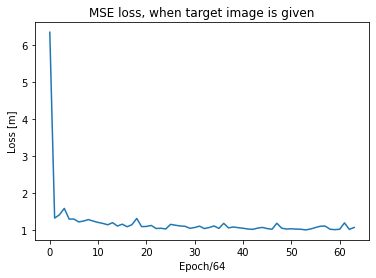

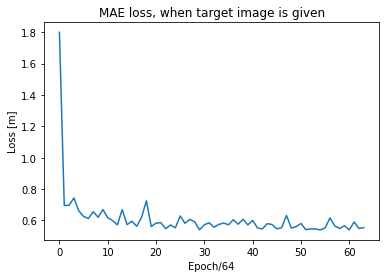

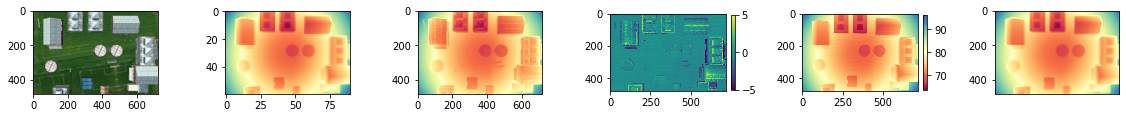

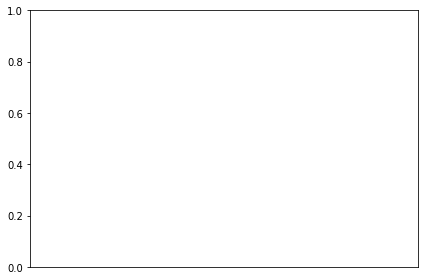

MSE: 1.058  ---  MAE: 0.572  ---  PBP: 0.160



####### image 2/3 - image idx 1 ########
weights: [0.01  0.01  0.001]


  0%|          | 0/1024 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [40]:
idxs = weights.shape[0]

for n_image in range(idxs):
    
    print("####### image {}/{} - image idx {} ########".format(n_image+1,idxs,n_image))
    print("weights: " + str(weights))
#    print("weights: " + str(weights[n_image,:]))
    guide_img = guide_imgs
    target_img = target_imgs
    source_img = downsample(target_img,params['scaling'])

    
    # use the indicated wights_regularizer
    params['weights_regularizer'] = weights
#         params['weights_regularizer'] = weights[n_image,:]
    bicubic_target_img = bicubic(source_img=source_img, scaling_factor=params['scaling'])
    
    predicted_target_img = PixTransform(guide_img=guide_img,source_img=source_img,params=params,target_img=target_img, path = None)
    


    if params['final_TGV'] :
        print("applying TGV...")
        predicted_target_img = tvgen(predicted_target_img,[0.1, 0.1],[1, 2],[1, 1])
        
    if params['align'] :
        print("aligning...")
        target_img,predicted_target_img = align_images(target_img,predicted_target_img)

    f, ax = plot_result(guide_img,source_img,predicted_target_img,bicubic_target_img,target_img)
    plt.show()
    
    if target_img is not None:
        # compute metrics and plot results
        MSE = np.mean((predicted_target_img - target_img) ** 2)
        MAE = np.mean(np.abs(predicted_target_img - target_img))
        PBP = np.mean(np.abs(predicted_target_img - target_img) > params["delta_PBP"])

        print("MSE: {:.3f}  ---  MAE: {:.3f}  ---  PBP: {:.3f}".format(MSE,MAE,PBP))
        print("\n\n")
 




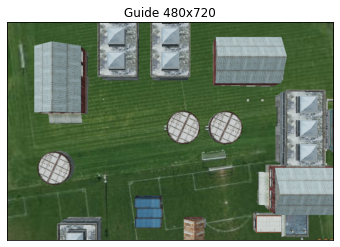

In [24]:
# Fine plotting 

# guide_img = np.rollaxis(guide_img, 0, 3)
plt.imshow(guide_img)
plt.tick_params(axis='x',which='both',bottom=False,top=False,labelbottom=False)
plt.tick_params(axis='y',which='both',left=False,right=False,labelleft=False)
plt.title('Guide 480x720')
plt.savefig(save_dir+'/G_2.png',bbox_inches='tight')
# plt.savefig('save_dir/G_5.png',bbox_inches='tight')

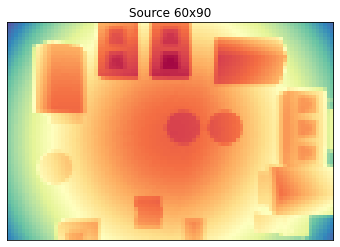

In [25]:
#source image
vmin = np.min(target_img)
vmax = np.max(target_img)
cmap = 'Spectral'

plt.imshow(source_img,vmin = vmin,vmax = vmax,cmap=cmap)
plt.tick_params(axis='x',which='both',bottom=False,top=False,labelbottom=False)
plt.tick_params(axis='y',which='both',left=False,right=False,labelleft=False)
plt.title('Source 60x90')
plt.savefig(save_dir+'/S_2.png',bbox_inches='tight')
# plt.savefig('save_dir/S_5.png',bbox_inches='tight')

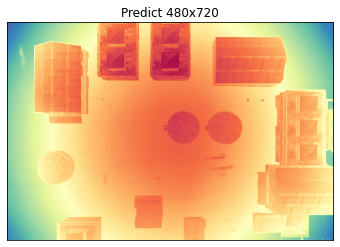

In [42]:
#predict

plt.imshow(predicted_target_img,vmin = vmin,vmax = vmax,cmap=cmap)
plt.tick_params(axis='x',which='both',bottom=False,top=False,labelbottom=False)
plt.tick_params(axis='y',which='both',left=False,right=False,labelleft=False)
plt.title('Predict 480x720')
# plt.savefig(save_dir+'/P_2_min.png',bbox_inches='tight')
plt.savefig(save_dir+'/P_2_max.png',bbox_inches='tight')
# plt.savefig('save_dir/P_5_min.png',bbox_inches='tight')
# plt.savefig('save_dir/P_5_max.png',bbox_inches='tight')

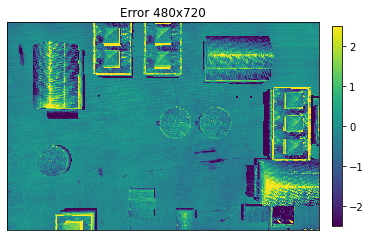

In [43]:
#error

error = plt.imshow(predicted_target_img-target_img,vmin = -2.5, vmax = 2.5,interpolation='none')
cbar1 = plt.colorbar(error,fraction=0.03,pad=0.04)
plt.tick_params(axis='x',which='both',bottom=False,top=False,labelbottom=False)
plt.tick_params(axis='y',which='both',left=False,right=False,labelleft=False)
plt.title('Error 480x720')
# plt.savefig(save_dir+'/E_2_min.png',bbox_inches='tight')
plt.savefig(save_dir+'/E_2_max.png',bbox_inches='tight')
# plt.savefig('save_dir/E_5_min.png',bbox_inches='tight')
# plt.savefig('save_dir/E_5_max.png',bbox_inches='tight')


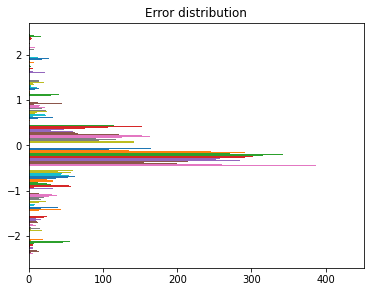

In [44]:
#error distribution

plt.figure(figsize=(4*1.5,3*1.5))
plt.hist(predicted_target_img-target_img,orientation='horizontal',range=(-2.5,2.5));
plt.title('Error distribution')
# plt.savefig(save_dir+'/D_2_min.png',bbox_inches='tight')
plt.savefig(save_dir+'/D_2_max.png',bbox_inches='tight')
# plt.savefig('save_dir/D_5_min.png',bbox_inches='tight')
# plt.savefig('save_dir/D_5_max.png',bbox_inches='tight')